In [10]:
from pypdf import PdfReader
import numpy as np 
import pandas as pd 
# from transformers import AutoModel, pipeline
# from openai import OpenAI
from Extract import Extract
from sentence_transformers import SentenceTransformer
import tensorflow as tf 
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


In [3]:
# initializing the cleaned text 
cleaned_sentences = pd.read_csv('cleaned_text.csv').drop(columns='Unnamed: 0')
cleaned_total_text = pd.read_csv('cleaned_text_total.csv').drop(columns='Unnamed: 0')
cleaned_sentences

,text,agency,dates
0,['Real gross domestic product is estimated toh...,US,2006-02-01
1,['The ongoing economic expansion has movedinto...,US,1999-07-01
2,"['Inadditiontothesepolicyactions,theFederal Re...",US,2012-02-01
3,"['Overall, the eco\xad nomic expansion was suf...",US,2005-07-01
4,['The Committee seeks to explain its monetary ...,US,2015-07-01
...,...,...,...
123,['T he nex t Stat ement is due f or release o...,Australia,2020-08-01
124,['The mat erial in this Stat ement on Monetar ...,Australia,2024-11-01
125,['T he nex t Stat ement is due f or release o...,Australia,2023-08-01
126,['T he nex t Stat ement is due f or release o...,Australia,2021-08-01


In [ ]:
# sentence by sentence array 
total_text = cleaned_total_text['text'].to_numpy()
## extracting separate sentences 
output_list = []
for i in range(0, total_text.shape[0]):
    curr_text = total_text[i]
    extractor = Extract(curr_text)
    output_list.append(extractor.extract_sentences())

small_out = output_list[1]
len(small_out)

287

In [5]:
## Getting embeddings 

output_matrix = [np.zeros(shape=(len(output_list[i]), 384)) for i in range(0, len(output_list))]
# iterating through all the output documents broken up by sentences 
for i in range(0, len(output_matrix)):
    curr_sentences=  output_list[i]
    embeddings = model.encode(curr_sentences, normalize_embeddings=True)
    output_matrix[i] = embeddings

In [55]:
## now generating the topic sentence embeddings to be used for similarity and grouping 
topic_sentences = pd.read_csv("Expanded_Forex_Sentence_Dataset.csv")
unique_factors = topic_sentences['Factor'].unique()
keyvec_matrix = np.zeros(shape=(10,384))
# final store of key vector embeddings 
i = 0 
key_topic_vecs = []
for topic in unique_factors.tolist():
    subset_df = topic_sentences.loc[topic_sentences['Factor']==topic]
    arr_sentences = subset_df['Sentence'].tolist()
    key_embeds = model.encode(arr_sentences, normalize_embeddings=True)
    mean_key_embeds = np.mean(key_embeds, axis=0, dtype=float)
    result_tuple = (topic, mean_key_embeds)
    print(mean_key_embeds.shape)
    keyvec_matrix[i,:] = mean_key_embeds.T
    i +=1
    key_topic_vecs.append(result_tuple)



(384,)
(384,)
(384,)
(384,)
(384,)
(384,)
(384,)
(384,)
(384,)
(384,)


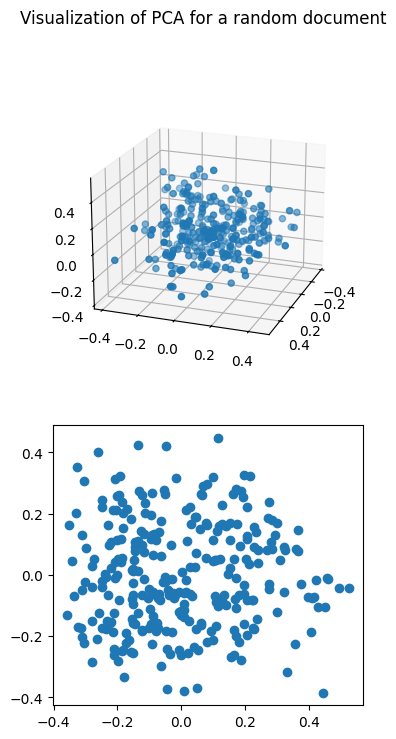

In [52]:
## initial visualization 3D and 2D 
pca_vecs = PCA(n_components=3)
matrix = output_matrix[1]
pca_doc_1= pca_vecs.fit_transform(matrix)
pca_2var = pca_vecs.fit_transform(matrix)

x_vars = pca_doc_1[:, 0]
y_vars = pca_doc_1[:,1]
z_vars = pca_doc_1[:,2]

x_2 = pca_2var[:,0]
y_2 = pca_2var[:,1]

fig = plt.figure(figsize=plt.figaspect(2.))
fig.suptitle("Visualization of PCA for a random document")

ax1 = fig.add_subplot(2,1,1, projection='3d')
ax1.scatter(x_vars,y_vars, z_vars)
ax1.view_init(elev=20 , azim=20, roll=0)
ax2 = fig.add_subplot(2,1,2)
ax2.scatter(x_2,y_2)

plt.show()

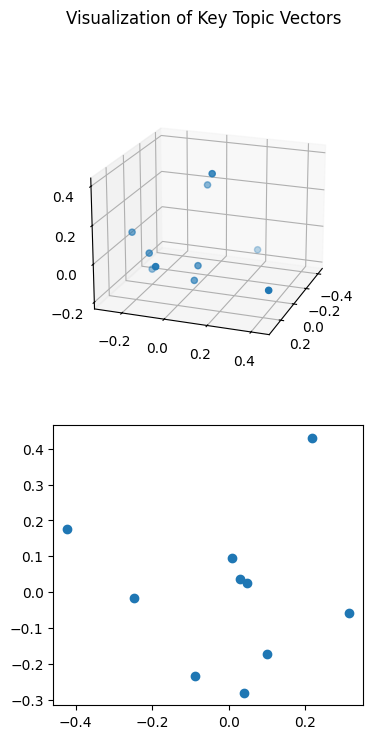

In [59]:
## Plotting key vecs in 2d and 3d 
pca_keys3 = PCA(n_components=3)
pca_keys2 = PCA(n_components=2)

out2 = pca_keys2.fit_transform(keyvec_matrix)
out3 = pca_keys3.fit_transform(keyvec_matrix)

x_2 = out2[:,0]
y_2 = out2[:,1]

x_3 = out3[:,0]
y_3 = out3[:,1]
z_3 = out3[:,2]

fig = plt.figure(figsize=plt.figaspect(2.))
fig.suptitle("Visualization of Key Topic Vectors")

ax1 = fig.add_subplot(2,1,1, projection='3d')
ax1.scatter(x_3,y_3, z_3)
ax1.view_init(elev=20 , azim=20, roll=0)
ax2 = fig.add_subplot(2,1,2)
ax2.scatter(x_2,y_2)

plt.show()